In [ ]:
from google.colab import files
files.upload()


Saving kaggle (2).json to kaggle (2).json


{'kaggle (2).json': b'{"username":"ashwinichoudhary","key":"7a28d2104e1d327dfbe9da80314a3d17"}'}

In [ ]:
!mv "kaggle (2).json" kaggle.json


In [ ]:
import os
import os
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json


In [ ]:
!kaggle datasets download -d prathumarikeri/indian-sign-language-isl



Dataset URL: https://www.kaggle.com/datasets/prathumarikeri/indian-sign-language-isl
License(s): CC-BY-SA-4.0
 99% 278M/281M [00:03<00:00, 89.9MB/s]
100% 281M/281M [00:03<00:00, 80.3MB/s]


In [ ]:
import zipfile
with zipfile.ZipFile("indian-sign-language-isl.zip", "r") as zip_ref:
    zip_ref.extractall("dataset")


In [ ]:
base_dir = "/content/dataset/Indian"

image_paths = []
labels = []

for folder_name in os.listdir(base_dir):
    folder_path = os.path.join(base_dir, folder_name)
    if os.path.isdir(folder_path):

        for image_name in os.listdir(folder_path):
            image_paths.append(os.path.join(folder_path, image_name))
            labels.append(folder_name)


In [ ]:

import pandas as pd

df = pd.DataFrame({
    'image_path': image_paths,
    'label': labels
})

df


,image_path,label
0,/content/dataset/Indian/8/727.jpg,8
1,/content/dataset/Indian/8/332.jpg,8
2,/content/dataset/Indian/8/1150.jpg,8
3,/content/dataset/Indian/8/606.jpg,8
4,/content/dataset/Indian/8/833.jpg,8
...,...,...
42740,/content/dataset/Indian/T/688.jpg,T
42741,/content/dataset/Indian/T/890.jpg,T
42742,/content/dataset/Indian/T/378.jpg,T
42743,/content/dataset/Indian/T/966.jpg,T


In [ ]:
import pandas as pd

rows_to_remove = 20000

drop_indices = df.sample(n=rows_to_remove, random_state=42).index

df = df.drop(drop_indices).reset_index(drop=True)

print(df.shape)


(22745, 2)


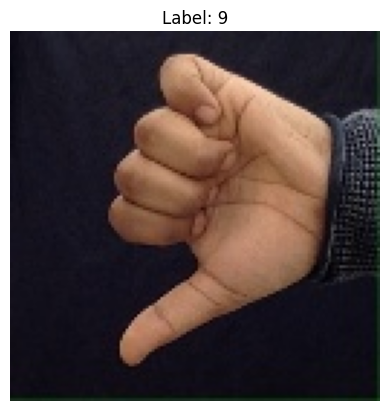

In [ ]:
import random
from tensorflow.keras.preprocessing.image import load_img
import matplotlib.pyplot as plt

def random_image_from_dataframe(df):

    random_row = df.sample(n=1).iloc[0]

    image_path = random_row['image_path']
    label = random_row['label']

    img = load_img(image_path)
    plt.imshow(img)
    plt.axis('off')
    plt.title(f"Label: {label}")
    plt.show()

random_image_from_dataframe(df)


In [ ]:
from sklearn.model_selection import train_test_split

train_df, test_df = train_test_split(df, test_size=0.2, random_state=42, stratify=df['label'])


In [ ]:
from tensorflow.keras.applications import VGG16, ResNet50
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.regularizers import l2

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.4,
    height_shift_range=0.4,
    shear_range=0.4,
    zoom_range=0.4,
    horizontal_flip=True,
    brightness_range=(0.5, 1.5),
    fill_mode='nearest'
)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col='image_path',
    y_col='label',
    target_size=(128, 128),
    color_mode='rgb',
    batch_size=32,
    class_mode='categorical',
    shuffle=True
)

test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    x_col='image_path',
    y_col='label',
    target_size=(128, 128),
    color_mode='rgb',
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

In [ ]:
from tensorflow.keras.applications import VGG16, ResNet50
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.regularizers import l2


# VGG16
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(128, 128, 3))

base_model.trainable = False


model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(128, activation='relu', kernel_regularizer=l2(0.002)),
    Dropout(0.5),
    Dense(35, activation='softmax')
])

model.compile(optimizer=Adam(learning_rate=5e-5),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Callbacks
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=3,
    min_lr=1e-6
)

# model
history = model.fit(
    train_generator,
    validation_data=test_generator,
    epochs=20,
    callbacks=[early_stopping, reduce_lr]
)


Found 18196 validated image filenames belonging to 35 classes.
Found 4549 validated image filenames belonging to 35 classes.
58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


569/569 ━━━━━━━━━━━━━━━━━━━━ 136s 221ms/step - accuracy: 0.0308 - loss: 4.1241 - val_accuracy: 0.1504 - val_loss: 3.6512 - learning_rate: 5.0000e-05
Epoch 2/20
569/569 ━━━━━━━━━━━━━━━━━━━━ 129s 213ms/step - accuracy: 0.0727 - loss: 3.7088 - val_accuracy: 0.3170 - val_loss: 3.4183 - learning_rate: 5.0000e-05
Epoch 3/20
569/569 ━━━━━━━━━━━━━━━━━━━━ 120s 210ms/step - accuracy: 0.1228 - loss: 3.5403 - val_accuracy: 0.4984 - val_loss: 3.2092 - learning_rate: 5.0000e-05
Epoch 4/20
569/569 ━━━━━━━━━━━━━━━━━━━━ 122s 213ms/step - accuracy: 0.1694 - loss: 3.3995 - val_accuracy: 0.6250 - val_loss: 3.0055 - learning_rate: 5.0000e-05
Epoch 5/20
569/569 ━━━━━━━━━━━━━━━━━━━━ 118s 204ms/step - accuracy: 0.2133 - loss: 3.2737 - val_accuracy: 0.7276 - val_loss: 2.8094 - learning_rate: 5.0000e-05
Epoch 6/20
569/569 ━━━━━━━━━━━━━━━━━━━━ 143s 206ms/step - accuracy: 0.2461 - loss: 3.1608 - val_accuracy: 0.8285 - val_loss: 2.6232 - learning_rate: 5.0000e-05
Epoch 7/20
569/569 ━━━━━━━━━━━━━━━━━━━━ 122s 213ms/

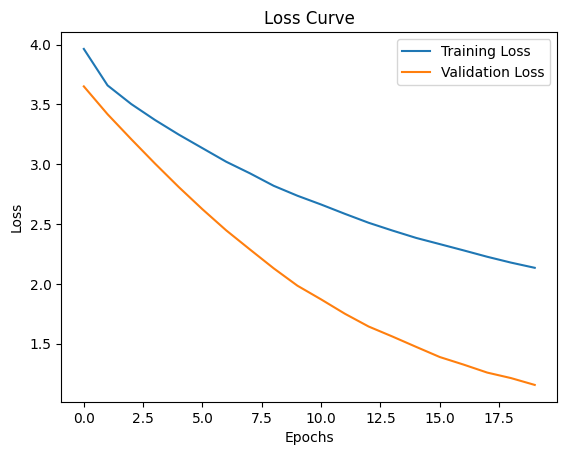

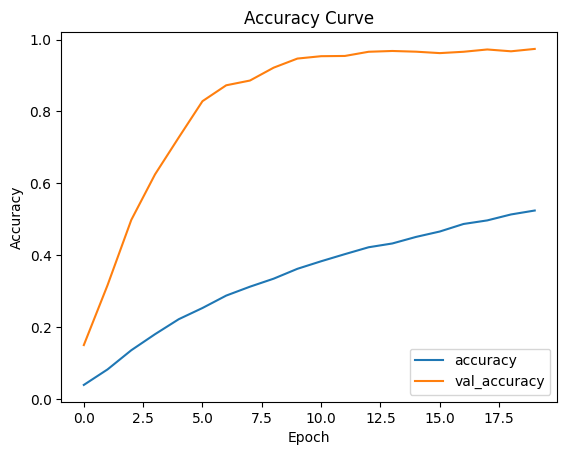

In [ ]:
# Loss curve
train_loss = history.history['loss']
val_loss = history.history['val_loss']
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Loss Curve')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot the accuracy
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy Curve')
plt.legend(loc='lower right')
plt.show()

In [ ]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

true_labels = test_generator.classes

class_indices = test_generator.class_indices
class_names = list(class_indices.keys())

predictions = model.predict(test_generator)
predicted_classes = np.argmax(predictions, axis=1)


143/143 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step


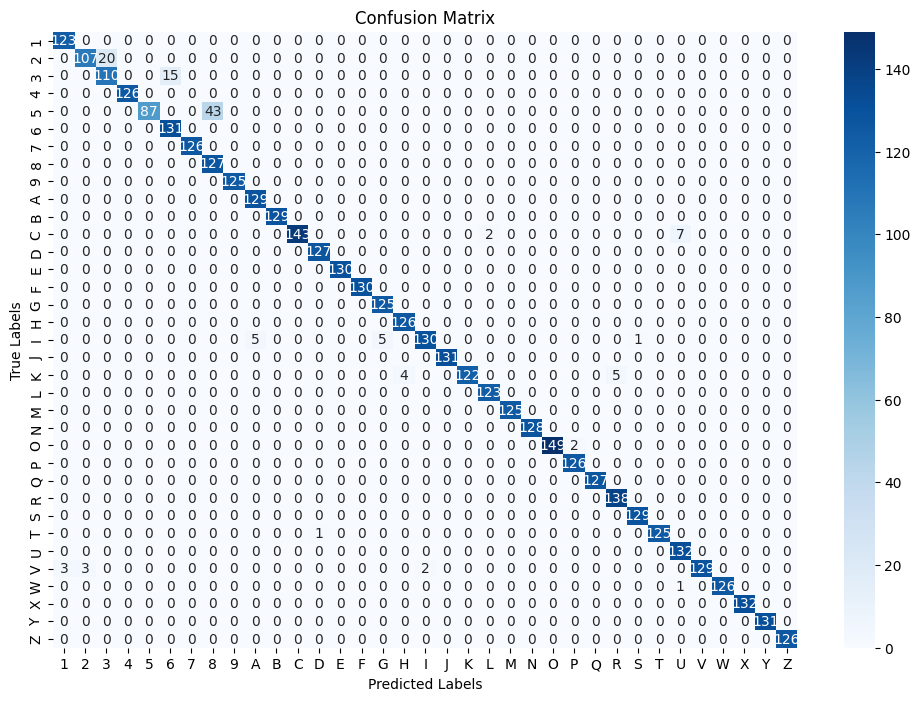

In [ ]:
cm = confusion_matrix(true_labels, predicted_classes)

plt.figure(figsize=(12, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()


In [ ]:

report = classification_report(true_labels, predicted_classes, target_names=class_names)
print(report)


              precision    recall  f1-score   support

           1       0.98      1.00      0.99       123
           2       0.97      0.84      0.90       127
           3       0.85      0.88      0.86       125
           4       1.00      1.00      1.00       126
           5       1.00      0.67      0.80       130
           6       0.90      1.00      0.95       131
           7       1.00      1.00      1.00       126
           8       0.75      1.00      0.86       127
           9       1.00      1.00      1.00       125
           A       0.96      1.00      0.98       129
           B       1.00      1.00      1.00       129
           C       1.00      0.94      0.97       152
           D       0.99      1.00      1.00       127
           E       1.00      1.00      1.00       130
           F       1.00      1.00      1.00       130
           G       0.96      1.00      0.98       125
           H       0.97      1.00      0.98       126
           I       0.98    